# Xarxa neuronal

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import SGD
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform as sp_rand
from scipy.stats import randint
from time import time
from sklearn import preprocessing

import math
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


## Consum diari total univariate one-step

In [2]:
daily=pd.read_csv('C:/Users/Laura/Desktop/Smart meters London/workspace R/Dades netes/Final/daily_agr_mitjanaLlarPerDia.csv')
daily.head(5)

,date,apparentTemperatureMax,sunsetTimeHour,weekday,season,cloudCover,humidity,visibility,month,energy_sum
0,2013-01-16,-0.15,16,3,winter,0.48,0.91,4.12,1,13.147536
1,2013-01-20,-0.46,16,7,winter,0.85,0.91,5.10,1,15.021900
2,2013-01-10,2.36,16,4,winter,0.70,0.94,5.21,1,12.066789
3,2013-01-06,6.98,16,7,winter,0.67,0.96,5.50,1,12.422263
4,2012-01-31,1.13,16,2,winter,0.55,0.84,5.62,1,13.890518


In [3]:
#Ens quedem amb date i energy_sum, ordenem valors per data i resetejem index
daily_dia=daily[['date','energy_sum']].sort_values(by=['date']).reset_index()
daily_dia.head(5)


,index,date,energy_sum
0,677,2011-11-23,6.952692
1,691,2011-11-24,8.536480
2,713,2011-11-25,9.499781
3,728,2011-11-26,10.267707
4,729,2011-11-27,10.850805


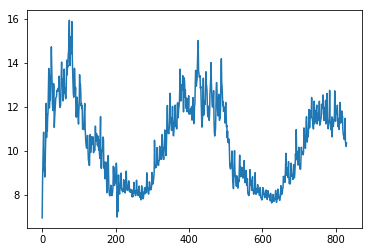

In [16]:
plt.plot(daily_dia )

In [4]:
daily_dia['t-1']=daily_dia['energy_sum'].shift(1)
daily_dia['t-2']=daily_dia['energy_sum'].shift(2)
daily_dia['t-3']=daily_dia['energy_sum'].shift(3)
daily_dia['t-4']=daily_dia['energy_sum'].shift(4)
daily_dia['t-5']=daily_dia['energy_sum'].shift(5)
daily_dia['t-6']=daily_dia['energy_sum'].shift(6)
daily_dia['t-7']=daily_dia['energy_sum'].shift(7)


daily_dia

,index,date,energy_sum,t-1,t-2,t-3,t-4,t-5,t-6,t-7
0,677,2011-11-23,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,691,2011-11-24,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,NaN
2,713,2011-11-25,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN
3,728,2011-11-26,10.267707,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN
4,729,2011-11-27,10.850805,10.267707,9.499781,8.536480,6.952692,NaN,NaN,NaN
5,704,2011-11-28,9.103382,10.850805,10.267707,9.499781,8.536480,6.952692,NaN,NaN
6,718,2011-11-29,9.274873,9.103382,10.850805,10.267707,9.499781,8.536480,6.952692,NaN
7,727,2011-11-30,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781,8.536480,6.952692
8,778,2011-12-01,9.227707,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781,8.536480
9,773,2011-12-02,10.145910,9.227707,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781


In [5]:
#Ens quedem amb energies
daily_dia=daily_dia[['energy_sum','t-1','t-2','t-3','t-4','t-5','t-6','t-7']]
daily_dia.head(5)


,energy_sum,t-1,t-2,t-3,t-4,t-5,t-6,t-7
0,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,NaN
2,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN
3,10.267707,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN
4,10.850805,10.267707,9.499781,8.536480,6.952692,NaN,NaN,NaN


In [6]:
#Eliminem les 7 primeres files ja que contenen NaN (valors buits)

daily_dia=daily_dia.drop([0,1,2,3,4,5,6])
daily_dia.head(5)

,energy_sum,t-1,t-2,t-3,t-4,t-5,t-6,t-7
7,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781,8.536480,6.952692
8,9.227707,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781,8.536480
9,10.145910,9.227707,8.813513,9.274873,9.103382,10.850805,10.267707,9.499781
10,10.780273,10.145910,9.227707,8.813513,9.274873,9.103382,10.850805,10.267707
11,12.163127,10.780273,10.145910,9.227707,8.813513,9.274873,9.103382,10.850805


In [39]:
len(daily_dia)


823

In [7]:
# definim model
import tensorflow as tf
model =Sequential()
model.add(LSTM(50, activation='relu', input_shape=(7, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
#Partim en X i y(valor a predir)


#normalitzem
scaler=preprocessing.MinMaxScaler(feature_range=(0, 1))
daily_dia_norm=scaler.fit_transform(daily_dia)

#Seleccionem dades per y i X
y_daily=daily_dia_norm[:,0]
X_daily=daily_dia_norm[:,1:8]


#Reshape de [samples,timesteps] a [samples,timesteps,features]
#X_daily_list=X_daily.values#.tolist()
X_daily=np.reshape(X_daily, (X_daily.shape[0],X_daily.shape[1],1))


In [44]:
X_daily[0]
daily_dia_norm

array([[0.20375985, 0.25530572, 0.2361457 , ..., 0.28043381, 0.17280805,
        0.        ],
       [0.250036  , 0.20375985, 0.25530572, ..., 0.36623108, 0.28043381,
        0.17622026],
       [0.35262316, 0.250036  , 0.20375985, ..., 0.43137821, 0.36623108,
        0.28340205],
       ...,
       [0.36928   , 0.38228562, 0.50172153, ..., 0.40043353, 0.41169419,
        0.42605687],
       [0.35899548, 0.36928   , 0.38228562, ..., 0.3942094 , 0.40043353,
        0.41412098],
       [0.37613476, 0.35899548, 0.36928   , ..., 0.42304761, 0.3942094 ,
        0.40290677]])

In [10]:

# definim model
import tensorflow as tf
model =Sequential()
model.add(LSTM(50, activation='relu', input_shape=(7, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


#Walk forward per test i train
minim=100
n_train=465
lenght=len(daily_dia)

llista_evaluate=list()
llista_prediccions=list()
llista_preditrain=list()
llista_scores=list()
llista_scoretrain=list()
sumScores=0

for i in range(n_train,lenght):
    minim=minim+1
    X_train,X_test= X_daily[minim:i],X_daily[i:i+1]
    y_train,y_test= y_daily[minim:i],y_daily[i:i+1]

    #fem fit al model
    model.fit(X_train, y_train, epochs=50, verbose=0)
    
    #mostrem score per cada model
    score=model.evaluate(X_test,y_test,verbose=0)
    llista_evaluate.append(score)
    
    #Predim per cadascun
    preditest=model.predict(X_test)
    llista_prediccions.append(preditest)
    
    preditrain=model.predict(X_train)
    llista_preditrain.append(preditrain)
    
    trainScore = math.sqrt(mean_squared_error(y_train, preditrain))
    llista_scoretrain.append(trainScore )
    

    testScore = math.sqrt(mean_squared_error(y_test, preditest))
    llista_scores.append(testScore)
   
    sumScores=sumScores+testScore
    


Instructions for updating:
Use tf.cast instead.


In [11]:
#Dividim la suma de scores de test entre el nombre de prediccions per obtenir la mitjana
sumScores/(lenght-n_train)


0.03935483565166944

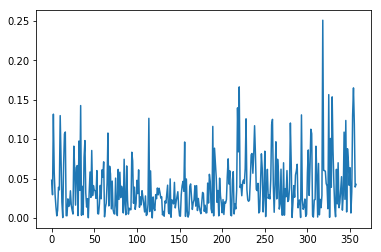

In [18]:
plt.plot(llista_scores)

In [12]:
predis=list()

for i in range(len(llista_prediccions)):
    predi=llista_prediccions[i].tolist()
    predis.append(predi)

predis=np.reshape(predis, (358)  )

predis

array([ 0.48804915,  0.48116875,  0.52007627,  0.62581819,  0.62542796,
        0.58745068,  0.53324944,  0.50420082,  0.54182315,  0.58864218,
        0.66909075,  0.56484556,  0.50241619,  0.50483775,  0.50104076,
        0.61280262,  0.69562191,  0.68760961,  0.66496444,  0.63937914,
        0.58003765,  0.56885421,  0.57093424,  0.53623843,  0.56202257,
        0.56274593,  0.56888103,  0.48957837,  0.59859759,  0.59371835,
        0.52535123,  0.46279198,  0.50020993,  0.40196937,  0.52260923,
        0.39545405,  0.41802436,  0.39990181,  0.41854599,  0.3584792 ,
        0.28190097,  0.25838739,  0.27698126,  0.27453393,  0.31160754,
        0.27768716,  0.29667521,  0.27277124,  0.1977337 ,  0.18542451,
        0.16483492,  0.24877556,  0.31255493,  0.29170656,  0.21272179,
        0.19648422,  0.19289121,  0.19796965,  0.18565354,  0.26348597,
        0.23668006,  0.21830527,  0.16771424,  0.17799339,  0.19853178,
        0.2112467 ,  0.20719621,  0.18854749,  0.19142768,  0.19

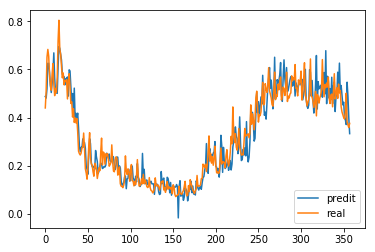

In [13]:
##Mostrem
plt.plot(predis, label="predit")
plt.plot(y_daily[n_train:lenght], label="real")
plt.legend(loc="lower right")
plt.show()

In [14]:

prova=daily_dia.iloc[n_train:lenght]
prova
#len(predis)
#lenght-n_train
prova['predi']=predis
prova['y']=y_daily[n_train:lenght]
prova=prova.drop(['energy_sum','t-1'], axis=1)
prova

c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\laura\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,t-2,t-3,t-4,t-5,t-6,t-7,predi,y
472,10.675248,10.860481,11.481859,12.735907,12.308851,12.048499,0.488049,0.440245
473,10.889469,10.675248,10.860481,11.481859,12.735907,12.308851,0.481169,0.510600
474,10.930170,10.889469,10.675248,10.860481,11.481859,12.735907,0.520076,0.651732
475,11.559878,10.930170,10.889469,10.675248,10.860481,11.481859,0.625818,0.683428
476,12.823073,11.559878,10.930170,10.889469,10.675248,10.860481,0.625428,0.654997
477,13.106773,12.823073,11.559878,10.930170,10.889469,10.675248,0.587451,0.573173
478,12.852295,13.106773,12.823073,11.559878,10.930170,10.889469,0.533249,0.535873
479,12.119938,12.852295,13.106773,12.823073,11.559878,10.930170,0.504201,0.514061
480,11.786082,12.119938,12.852295,13.106773,12.823073,11.559878,0.541823,0.580609
481,11.590859,11.786082,12.119938,12.852295,13.106773,12.823073,0.588642,0.624326


In [15]:
# Convert predictions back to normal values

predi = scaler.inverse_transform(prova)
print(predi)
print(predi[0][6])
print(predi[0][7])


[[102.53827552 104.19619152 109.75782223 ... 114.82951586  11.35803653
   10.90941785]
 [104.45565387 102.53827552 104.19619152 ... 117.15978906  11.29645368
   11.54173402]
 [104.81994666 104.45565387 102.53827552 ... 120.98214256  11.64469441
   12.81016101]
 ...
 [109.74485905 103.44221738 101.13196088 ... 103.4928401   11.36003231
   10.27161324]
 [100.17673598 109.74485905 103.44221738 ... 102.5326838   10.55380722
   10.17918068]
 [ 99.13484299 100.17673598 109.74485905 ... 101.63058181   9.9750808
   10.33322068]]
11.35803652710475
10.909417847727964


In [16]:
#Fem una llista amb les prediccions i una llista amb y(valor real)

listpredi=list()
for i in range(len(predi)):
    listpredi.append(predi[i][6])
listpredi

listy=list()
for i in range(len(predi)):
    listy.append(predi[i][7])
listy

[10.909417847727964,
 11.541734015843437,
 12.810161008052187,
 13.095036372869387,
 12.839504586908841,
 12.104113874587336,
 11.768874594549265,
 11.5728434534286,
 12.170938362994406,
 12.563854805851543,
 11.799491807423067,
 11.368769171374655,
 11.645498007385225,
 11.486383766157797,
 12.055146498912347,
 13.418870046058563,
 14.18434826454072,
 13.106605940356959,
 12.904034964148906,
 12.481777834780083,
 12.034844377299484,
 12.216213953779874,
 11.774720732675483,
 11.916121209122355,
 11.916121209122355,
 11.96602913488797,
 11.246891425520584,
 11.906586850226484,
 12.186487843286868,
 11.714046017023353,
 11.077116388183462,
 11.138487728712652,
 10.57127320547445,
 10.879512180409455,
 10.368387785899902,
 10.537463985883184,
 10.349229865851477,
 10.50921411168254,
 10.019834486664964,
 9.292251119455212,
 9.202081418270591,
 9.151266909548587,
 9.222557748636955,
 9.422124723547805,
 9.458964521083429,
 9.972057279719857,
 9.384480482677608,
 8.6351294416642,
 8.475305

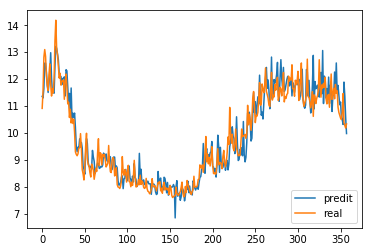

In [17]:
##Mostrem
plt.plot(listpredi, label="predit")
plt.plot(listy, label="real")
plt.legend(loc="lower right")
plt.show()